In [18]:
import pandas as pd
import numpy as np
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string as str

# LECTURA DE LOS DATOS

In [19]:
with open('GSAF5.csv') as csvfile:   
    raw_data = pd.read_csv('GSAF5.csv', encoding='latin-1')
raw_data.head(1)

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN


# HIPÓTESIS DE TRABAJO

In [48]:
# La hipótesis radica en que existe una relación entre los ataques de tiburón y la actividad turística en 
# zonas costeras

# COLUMNS

### Nombres de las columnas:

In [20]:
raw_data.columns

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')

In [21]:
raw_data.dtypes

Case Number               object
Date                      object
Year                       int64
Type                      object
Country                   object
Area                      object
Location                  object
Activity                  object
Name                      object
Sex                       object
Age                       object
Injury                    object
Fatal (Y/N)               object
Time                      object
Species                   object
Investigator or Source    object
pdf                       object
href formula              object
href                      object
Case Number.1             object
Case Number.2             object
original order             int64
Unnamed: 22               object
Unnamed: 23               object
dtype: object

In [22]:
# Conviene unificar los nombres de las columnas con un mismo formato. Algunas anomalías detectadas son: 
#      * espacios en blanco al inicio o al final del nombre, 
#      * espacios en blanco separando nombres compuestos,
#      * caracteres extraños: ':', paréntesis, '/'
#      * unos nomvres empiezan con mayúscula y otros con minúscula
 
# Como los nombres de las columnas son un tipo 'Index', podemos usar los StringMethods.
raw_data.columns = raw_data.columns.str.strip()\
                                   .str.lower()\
                                   .str.replace(' ', '_')\
                                   .str.replace('(', '')\
                                   .str.replace(')', '')\
                                   .str.replace('/', '-')\
                                   .str.replace(':', '')

raw_data.columns   

Index(['case_number', 'date', 'year', 'type', 'country', 'area', 'location',
       'activity', 'name', 'sex', 'age', 'injury', 'fatal_y-n', 'time',
       'species', 'investigator_or_source', 'pdf', 'href_formula', 'href',
       'case_number.1', 'case_number.2', 'original_order', 'unnamed_22',
       'unnamed_23'],
      dtype='object')

### Número de registros por columnas

In [23]:
raw_data.count() 

case_number               5992
date                      5992
year                      5992
type                      5992
country                   5949
area                      5590
location                  5496
activity                  5465
name                      5792
sex                       5425
age                       3311
injury                    5965
fatal_y-n                 5973
time                      2779
species                   3058
investigator_or_source    5977
pdf                       5992
href_formula              5991
href                      5989
case_number.1             5992
case_number.2             5992
original_order            5992
unnamed_22                   1
unnamed_23                   2
dtype: int64

### Aparente repetición de columnas: 'case_number', 'case_number.1' y 'case_number.2'. Los nombres son similares y el número de registros idéntico (en una hoja de cálculo se ve claramente  que son columnas duplicadas)

### Comprobación 1: 'case_number' y 'case_number.1'

In [24]:
raw_data.loc[:, ['case_number', 'case_number.1']].head()

,case_number,case_number.1
0,2016.09.18.c,2016.09.18.c
1,2016.09.18.b,2016.09.18.b
2,2016.09.18.a,2016.09.18.a
3,2016.09.17,2016.09.17
4,2016.09.15,2016.09.16


In [25]:
same_cols = []
for col in raw_data:
    if ['case_number'] != ['case_number.1']:
        same_cols.append(1)
if sum(same_cols) == len('case_number') == len('case_number.1'):
    print('"case_number" y "case_number.1" son columnas idénticas, se borra "case_number.1"')
    raw_data.drop(['case_number.1'], axis=1, inplace=True)
elif sum(same_cols) / len(['case_number']) > 0.80 and sum(same_cols) / len(['case_number.1']) > 0.80:  # coincidencia del 80%
    print('Las columnas son muy parecidas, se borra "case_number.1"')
    raw_data.drop(['case_number.1'], axis=1, inplace=True)
else:
    print('Las columnas no son similares, ninguna acción a realizar')


Las columnas son muy parecidas, se borra "case_number.1"


### Comprobación 2: 'case_number' y 'case_number.2'

In [26]:
# Caso igual que el anterior. Se borra 'case_number.2'
raw_data.drop(['case_number.2'], axis=1, inplace=True)

In [27]:
# Creé una función para esa tarea, pero salta error al aplicarla al dataframe
def similar_cols(col1, col2):
    same_cols = []
    for col in raw_data:
        if col1 != col2:
            same_cols.append(1)
    if sum(same_cols) == len(col1) == len(col2):
        print('{} y {} son columnas idénticas'.format(col1, col2))
        raw_data.drop(col1, axis=1, inplace=True)
    elif sum(same_cols) / len(col1) > 0.80 and sum(same_cols) / len(col2) > 0.80:  # coincidencia del 80%
        print('Las columnas son muy parecidas')
        raw_data.drop(col1, axis=1, inplace=True)
    else:
        print('Las columnas no son similares, ninguna acción a realizar')

In [28]:
#raw_data.loc[:,['case_number', 'case;number.1']].apply(similar_cols(raw_data['case_number'], raw_data['case_number.1'])\
#                                                                                                               , axis=1)

# ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### Aparente repetición de columnas: 'href formula' y 'href'. Los nombres son similares y el número de registros casi idéntico. 

In [29]:
# Caso igual que el anterior. Se borra 'href'
raw_data.drop(['href'], axis=1, inplace=True)

### Aparente repetición de columnas: 'pdf' y 'href'. Contienen la misma información 

In [30]:
# Caso igual que el anterior. Se borra 'pdf'
raw_data.drop(['pdf'], axis=1, inplace=True)

### Las columnas 'unnamed_22' y 'unnamed_23' tienen sólo 1 y 2 registros, se borran:

In [31]:
cols_to_drop = ['unnamed_22', 'unnamed_23']
raw_data.drop(cols_to_drop, axis=1, inplace=True)  
# Se utiliza el parámetro 'inplace' para que la eliminación de la columna se efectúe de inmediato. Así se evita la 
# asignación a un nuevo dataframe.
raw_data.head()

,case_number,date,year,type,country,area,location,activity,name,sex,age,injury,fatal_y-n,time,species,investigator_or_source,href_formula,original_order
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,"Orlando Sentinel, 9/19/2016",http://sharkattackfile.net/spreadsheets/pdf_di...,5993
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,"Orlando Sentinel, 9/19/2016",http://sharkattackfile.net/spreadsheets/pdf_di...,5992
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,"Orlando Sentinel, 9/19/2016",http://sharkattackfile.net/spreadsheets/pdf_di...,5991
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,"The Age, 9/18/2016",http://sharkattackfile.net/spreadsheets/pdf_di...,5990
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,"The Age, 9/16/2016",http://sharkattackfile.net/spreadsheets/pdf_di...,5989


# MISSING VALUES

### Función que muestra el porcentaje de missing values por columnas

In [32]:
def calculate_missing_pct(dataframe):   
    # devuelve el número de registros del dataframe:
    total_values = dataframe.count() 
    # número de valores nulos por columna. Valores nulos valen 0, no nulos valen 1. sum() suma los unos:
    missing_values = dataframe.isnull().sum() 
    # valores nulos por columnas respecto al total de registros, en orden descendiente:
    missing_pct = (missing_values / total_values * 100).sort_values(0, ascending=False)    
    return missing_pct  

calculate_missing_pct(raw_data)

time                      115.617128
species                    95.945062
age                        80.972516
sex                        10.451613
activity                    9.643184
location                    9.024745
area                        7.191413
name                        3.453039
country                     0.722811
injury                      0.452640
fatal_y-n                   0.318098
investigator_or_source      0.250962
href_formula                0.016692
year                        0.000000
date                        0.000000
original_order              0.000000
type                        0.000000
case_number                 0.000000
dtype: float64

In [34]:
# Ninguna de las columnas con altos porcentajes de missing values son objeto del estudio, por lo que 
# puede obviarse este problema.


# SELECCIÓN DE LAS COLUMNAS PARA EL ESTUDIO

### El dataframe queda así:

In [35]:
columns = ['case_number','year','country', 'area', 'location', 'activity']
data = raw_data[columns]
data.head()

,case_number,year,country,area,location,activity
0,2016.09.18.c,2016,USA,Florida,"New Smyrna Beach, Volusia County",Surfing
1,2016.09.18.b,2016,USA,Florida,"New Smyrna Beach, Volusia County",Surfing
2,2016.09.18.a,2016,USA,Florida,"New Smyrna Beach, Volusia County",Surfing
3,2016.09.17,2016,AUSTRALIA,Victoria,Thirteenth Beach,Surfing
4,2016.09.15,2016,AUSTRALIA,Victoria,Bells Beach,Surfing


# DATOS EXPLORATORIOS

### AÑOS CON MÁS ATAQUES: el mayor número de ataques sucede durante los últimos años.

In [36]:
# Agrupa por años y cuenta, ordena los resultados y añade columna con los mismos.
worse_years = data.groupby(['year'])['case_number']\
                  .count()\
                  .sort_values(0, ascending=False)\
                  .reset_index(name="#attacks")
worse_years.head(10)

,year,#attacks
0,2015,139
1,2011,128
2,2014,125
3,0,124
4,2013,122
5,2008,121
6,2009,120
7,2012,117
8,2007,112
9,2005,103


### Gráfica de ataques por años desde 2000 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

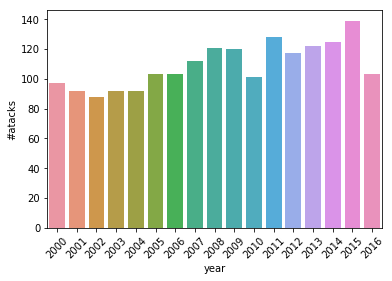

In [37]:
# Limita rango de años a mayores de 1999, agrupa por años y cuenta.
atacks_by_year = data[data['year'] > 1999].groupby(['year'])['case_number']\
                                          .count()\
                                          .reset_index(name="#atacks")
# parámetros del gráfico
sns.barplot(data = atacks_by_year, x = 'year', y = '#atacks')
plt.xticks(rotation=45)

### PAISES DONDE SE DA EL MAYOR NÚMERO DE ATAQUES: El primero es EE.UU.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

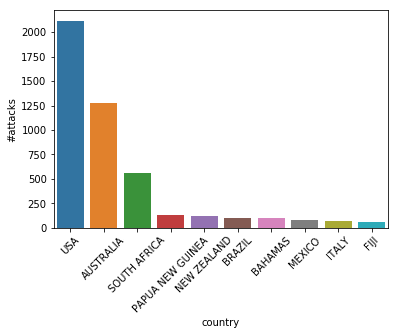

In [38]:
attacks_by_countries = data.groupby(['country'])['case_number']\
                           .count()\
                           .sort_values(0, ascending=False)\
                           .reset_index(name='#attacks')

# parámetros del gráfico
graph_attacks_by_countries = attacks_by_countries.head(10)
sns.barplot(data = graph_attacks_by_countries, x = 'country', y = '#attacks')
plt.xticks(rotation=45)

### ÁREAS DE EE.UU. CON MAYOR NÚMERO DE ATAQUES: La primera es Florida.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

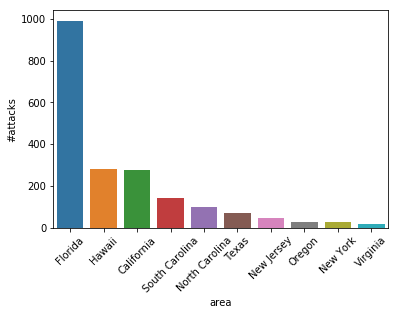

In [39]:
usa = data[data['country']=='USA']
usa_area = usa.groupby(['area'])['case_number']\
              .count()\
              .sort_values(0, ascending=False)\
              .reset_index(name='#attacks')

# parámetros del gráfico
graph_usa_area = usa_area.head(10)
sns.barplot(data = graph_usa_area, x = 'area', y = '#attacks')
plt.xticks(rotation=45)

### ATAQUES POR EMPLAZAMIENTOS EN FLORIDA: la mayoría suceden en New Smyrna Beach, Volusia County

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

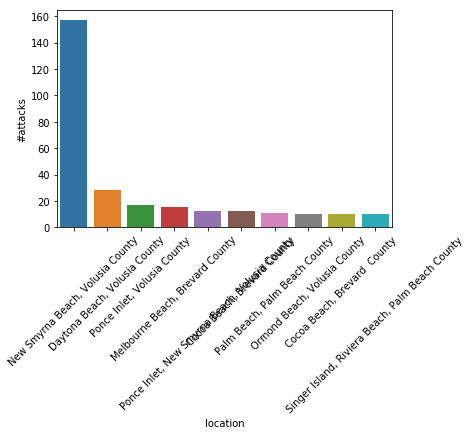

In [40]:
FL = data[data['area']=='Florida']
FL_location = FL.groupby(['location'])['case_number']\
                .count()\
                .sort_values(0, ascending=False)\
                .reset_index(name='#attacks')

# parámetros del gráfico
graph_FL_location = FL_location.head(10)
sns.barplot(data = graph_FL_location, x = 'location', y = '#attacks')
plt.xticks(rotation=45)

### EMPLAZAMIENTOS DEL MUNDO CON MÁS ATAQUES: New Smyrna Beach, Volusia County

In [41]:
worse_location = data.groupby(['location'])['case_number']\
                     .count()\
                     .sort_values(0, ascending=False)\
                     .reset_index(name='#attacks')
worse_location.head()

,location,#attacks
0,"New Smyrna Beach, Volusia County",157
1,"Daytona Beach, Volusia County",28
2,"Ponce Inlet, Volusia County",17
3,"Myrtle Beach, Horry County",17
4,Durban,15


## activity

In [42]:
activ = data.groupby(['activity'])['case_number']\
            .count()\
            .sort_values(0, ascending=False)\
            .reset_index(name='#attacks')
activ.head()


,activity,#attacks
0,Surfing,904
1,Swimming,819
2,Fishing,414
3,Spearfishing,321
4,Bathing,153


In [ ]:
activ2 = data['year'].sort_values(0, ascending=False)\
                     .groupby(['activity'])['case_number']\

In [46]:
year_activ = data.groupby(['year','activity'])['activity']\
                 .count()\
                 .sort_values(0, ascending=False)\
                 .reset_index(name="#attacks")
year_activ

,year,activity,#attacks
0,2012,Surfing,42
1,2015,Surfing,40
2,2009,Surfing,39
3,2007,Surfing,38
4,2008,Surfing,38
5,2011,Surfing,36
6,2014,Surfing,35
7,2005,Surfing,35
8,2003,Surfing,34
9,2010,Surfing,34
